In [1]:
%matplotlib inline

import pandas
import pickle
import matplotlib.pyplot as plt
import numpy as np
from patsy import *
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
import scipy, scipy.stats
from math import *
import seaborn as sns


In [2]:
# Pickling functions
def pickle_it(data, filename):
    with open(filename, "wb") as picklefile:
        pickle.dump(data, picklefile)

def load_pickle(filename):
    with open(filename, "rb") as picklefile: 
        return pickle.load(picklefile)

In [3]:
d = load_pickle('fixyear.pkl')
len(d)

4151

***Here I begin with 4151 rows of data***

In [4]:
df = pandas.DataFrame(d)
#print df.dtypes
print df.count()

Budget          767
Gross           424
Metascore       258
OpeningWkd      323
ReleaseDate    3189
Runtime        2742
Title          4151
Year           3838
dtype: int64


**.count() shows all the non NaN or NaT values for each column. if I'm to use max features 258 is max possible rows of data**

In [5]:
logdf = df
logdf['Budget'] = logdf['Budget'].apply(lambda x: np.log(x))
logdf['Gross'] = logdf['Gross'].apply(lambda x: np.log(x))
logdf['OpeningWkd'] = logdf['OpeningWkd'].apply(lambda x: np.log(x))


In [6]:
logdf

,Budget,Gross,Metascore,OpeningWkd,ReleaseDate,Runtime,Title,Year
0,11.512925,NaN,NaN,NaN,2015-10-30,84,Beautiful Danger 3D Animated Teen Thriller,2015
1,NaN,NaN,NaN,NaN,NaT,NaN,Network E.L.E. - IMDb,NaN
2,NaN,NaN,NaN,NaN,2014-10-06,75,Rimolar ve Zimolar: Kasabada Baris,2014
3,NaN,NaN,NaN,NaN,2009-06-13,72,Miyamoto Musashi: Sôken ni haseru yume,2009
4,NaN,NaN,NaN,NaN,2007-09-12,NaN,Saint Anthony,2007
5,NaN,11.643304,NaN,7.077498,2009-06-27,112,Evangerion shin gekijôban: Ha,2009
6,NaN,11.175605,NaN,NaN,1994-10-07,76,A Troll in Central Park,1994
7,NaN,17.380769,NaN,NaN,1995-04-07,78,A Goofy Movie,1995
8,NaN,NaN,NaN,NaN,2005-10-06,NaN,Lado B,1998
9,NaN,12.847232,NaN,12.326807,2003-10-16,100,Lian zhi feng jing,2003


In [ ]:
pandas.tools.plotting.scatter_matrix(logdf[['Budget','Gross', 'Metascore', 'OpeningWkd', 'ReleaseDate', 'Runtime', 'Year']] , alpha=0.2, figsize=(15, 15), diagonal='hist')


In [ ]:
plt.show()

In [5]:
#import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            print formula
            score = smf.ols(formula, data).fit().rsquared_adj 
            print score
            print
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model


In [ ]:
model = forward_selected(logdf,'Gross')

In [ ]:
print model.model.formula
print model.rsquared_adj
model.summary()

In [6]:
cleandf = df[df['Year'] <= 2015].dropna()


In [7]:
logcleandf = cleandf
logcleandf['Budget'] = logcleandf['Budget'].apply(lambda x: np.log(x))
logcleandf['Gross'] = logcleandf['Gross'].apply(lambda x: np.log(x))
logcleandf['OpeningWkd'] = logcleandf['OpeningWkd'].apply(lambda x: np.log(x))

In [ ]:
logcleandf

In [ ]:
pandas.tools.plotting.scatter_matrix(cleandf , alpha=0.2, figsize=(15, 15), grid=True, diagonal='hist')
plt.savefig(r"clean_scattermatrix.png")

In [ ]:
pandas.tools.plotting.scatter_matrix(logcleandf , alpha=0.2, figsize=(15, 15),  grid=True, diagonal='hist')
plt.savefig(r"logclean_scattermatrix.png")


In [ ]:
axes = pandas.tools.plotting.scatter_matrix(df, alpha=0.2)
plt.tight_layout()
plt.show()

In [8]:
cleanmodel = forward_selected(logcleandf, 'Gross')

Gross ~ OpeningWkd + 1
0.406215698011

Gross ~ Title + 1
nan

Gross ~ Budget + 1
0.108143123598

Gross ~ Metascore + 1
-0.00547814159567

Gross ~ ReleaseDate + 1
0.811568521826

Gross ~ Year + 1
0.0419416734499

Gross ~ Runtime + 1
0.00953349317663

Gross ~ ReleaseDate + OpeningWkd + 1
0.976518365651

Gross ~ ReleaseDate + Title + 1
nan

Gross ~ ReleaseDate + Budget + 1
0.796727035248

Gross ~ ReleaseDate + Metascore + 1
0.994377928236

Gross ~ ReleaseDate + Year + 1
0.812705286206

Gross ~ ReleaseDate + Runtime + 1
0.645843426339

Gross ~ ReleaseDate + Metascore + OpeningWkd + 1
nan

Gross ~ ReleaseDate + Metascore + Title + 1
nan

Gross ~ ReleaseDate + Metascore + Budget + 1
nan

Gross ~ ReleaseDate + Metascore + Year + 1
nan

Gross ~ ReleaseDate + Metascore + Runtime + 1
nan



In [9]:
print cleanmodel.model.formula
print cleanmodel.rsquared_adj

Gross ~ ReleaseDate + Metascore + 1
0.994377928236


In [11]:
noRelease = logcleandf[['Budget', 'Gross', 'Year', 'Runtime', 'Metascore', 'OpeningWkd']]

In [11]:
meowdel = forward_selected(noRelease,'Gross')


Gross ~ OpeningWkd + 1
0.406215698011

Gross ~ Budget + 1
0.108143123598

Gross ~ Metascore + 1
-0.00547814159567

Gross ~ Year + 1
0.0419416734499

Gross ~ Runtime + 1
0.00953349317663

Gross ~ OpeningWkd + Budget + 1
0.406276105507

Gross ~ OpeningWkd + Metascore + 1
0.404191579429

Gross ~ OpeningWkd + Year + 1
0.428285003224

Gross ~ OpeningWkd + Runtime + 1
0.407708765718

Gross ~ OpeningWkd + Year + Budget + 1
0.42755670803

Gross ~ OpeningWkd + Year + Metascore + 1
0.428046543723

Gross ~ OpeningWkd + Year + Runtime + 1
0.426636822706



In [12]:
print meowdel.model.formula
meowdel.rsquared_adj


Gross ~ OpeningWkd + Year + 1


0.42828500322363228

In [ ]:
y, X = dmatrices('Gross ~ Budget + Year + ReleaseDate + OpeningWkd + Runtime + Metascore', data = df, return_type = 'dataframe')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
len(X_train)

In [ ]:
axes = pandas.tools.plotting.scatter_matrix(cleandf, alpha=0.2)

In [ ]:
plt.tight_layout()

plt.show()


In [ ]:
model = sm.OLS(y,X)

In [ ]:
results = model.fit()

In [ ]:
print type(model)
print type(results)

In [ ]:
results.summary()

In [ ]:
results = smf.ols(formula = "Gross ~ Budget + OpeningWkd + Runtime + Year + Metascore", data = df).fit()

In [ ]:
print results.params

In [ ]:


model = LinearRegression()
model.fit(X, y)

In [ ]:
model.score(X,y)

In [ ]:
model.coef_

In [ ]:
model.intercept_

In [ ]:

plt.plot(y.sort('Gross'), X.sort(['Budget']), alpha = 0.5)
plt.show()

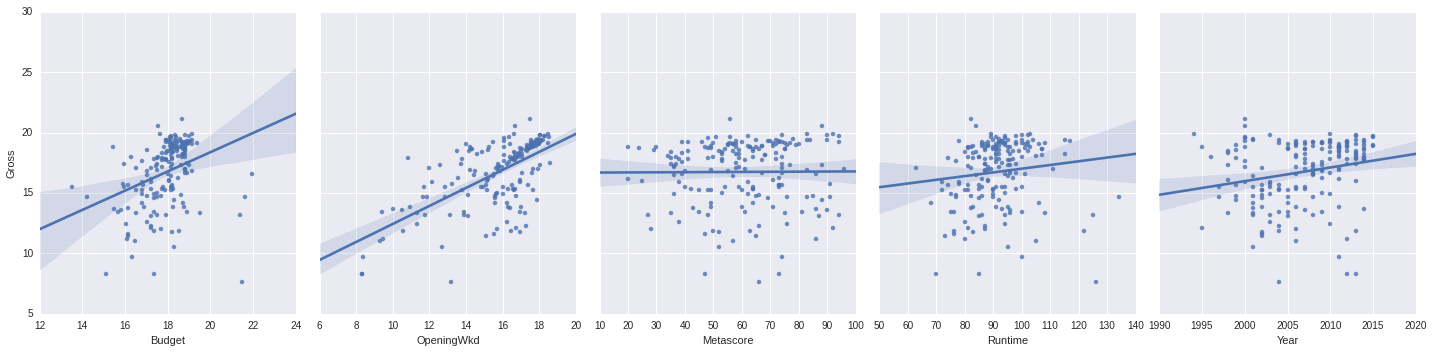

In [39]:
pair=sns.pairplot(noRelease, x_vars = ['Budget', 'OpeningWkd', 'Metascore', 'Runtime', 'Year'], y_vars = ['Gross'], 
             size = 5, aspect =.8, kind = 'reg')

In [ ]:
g = sns.PairGrid(iris)
>>> g = g.map(plt.scatter)

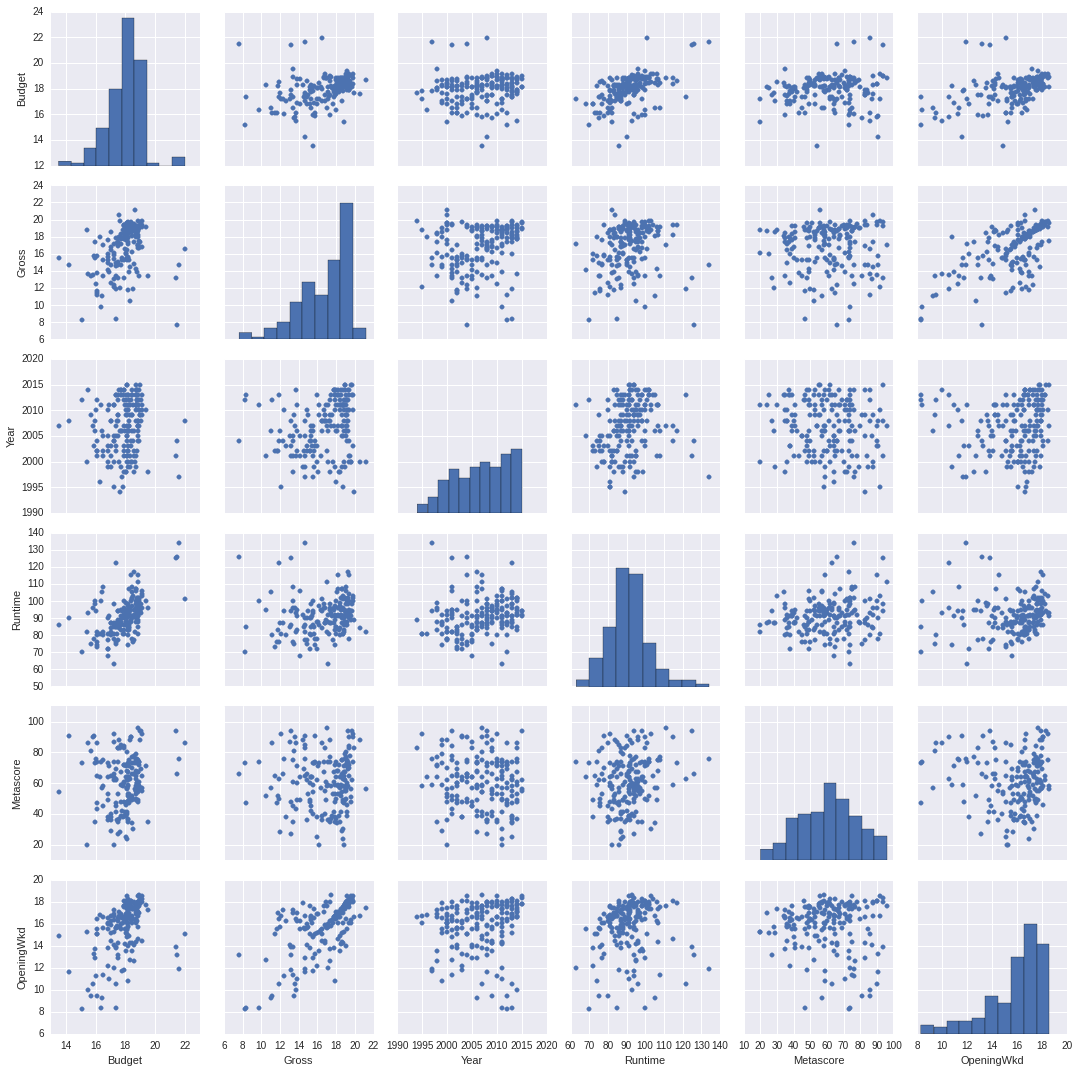

In [17]:

g = sns.PairGrid(noRelease)
#g = g.map(plt.scatter)

g = g.map_offdiag(plt.scatter)
g = g.map_diag(plt.hist)

In [26]:
g.plt.show()

AttributeError: 'PairGrid' object has no attribute 'plt'

In [ ]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

print(get_season(date.today()))